# 1. Create Spark Session & Import Libraries

In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/27 14:43:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/27 14:43:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# 2. Define Schema & Data Preprocessing

In [2]:
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))
df.printSchema()
df.show(5, truncate=False)

columns_to_drop = [
    'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
df_cleaned = df.drop(*columns_to_drop)


df_cleaned = df_cleaned.dropna(subset=[
    "ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"
])

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

25/04/27 14:43:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE              |AIRLINE_DOT              |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY        |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+

# 3. Feature Engineering

In [5]:
delay_threshold = 10

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))     # dep hour
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))   # dep minute
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))     # arrival hour
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))   # arrival minute
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE") / (F.col("CRS_ELAPSED_TIME") + 1e-6))


featureCols = [
    "AIRLINE_CODE", "ORIGIN", "DEST",
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE",
    "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR",
    "IS_WEEKEND", "DISTANCE_PER_MINUTE"
]

labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol, "FL_DATE"])
final_df.printSchema()
final_df.show(5, truncate=False)

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- FL_DATE: date (nullable = true)

+------------+------+----+----------------+--------+--------+----------+--------+----------+---------------+---------+----------------+----------------+----------+-------------------+------------+----------+
|AIRLINE_CODE|ORIGIN|DEST|CRS_ELAPSED_TIME|DIS

# 4. Making Visualizations

Plotting with 29276 samples.


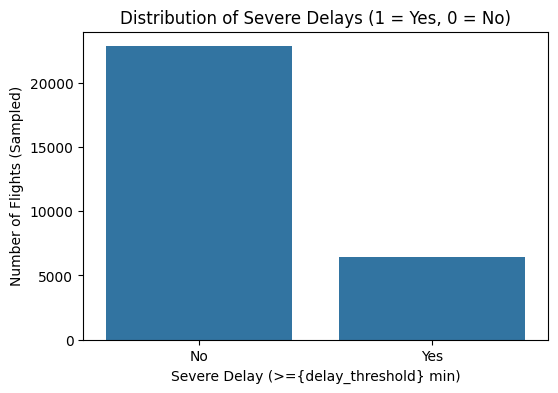

In [6]:
plot_sample_df = final_df.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
print(f"Plotting with {len(plot_sample_df)} samples.") # doing a sample because it was too large otherwise

# 1. Distribution of Severe Delays
plt.figure(figsize=(6, 4))
sns.countplot(x='SEVERE_DELAY', data=plot_sample_df)
plt.title('Distribution of Severe Delays (1 = Yes, 0 = No)')
plt.xlabel('Severe Delay (>={delay_threshold} min)')
plt.ylabel('Number of Flights (Sampled)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [7]:
# Getting imbalance ratio but using the full dataset for accuracy
target_counts = final_df.groupBy('SEVERE_DELAY').count().toPandas()
print("\nSevere Delay Distribution (Full Data):")
print(target_counts)
if len(target_counts) == 2:
    imbalance_ratio = target_counts['count'].min() / target_counts['count'].max()
    print(f"Imbalance Ratio: {imbalance_ratio:.4f}")

[Stage 5:=============================>                             (4 + 4) / 8]


Severe Delay Distribution (Full Data):
   SEVERE_DELAY    count
0             1   645404
1             0  2268398
Imbalance Ratio: 0.2845


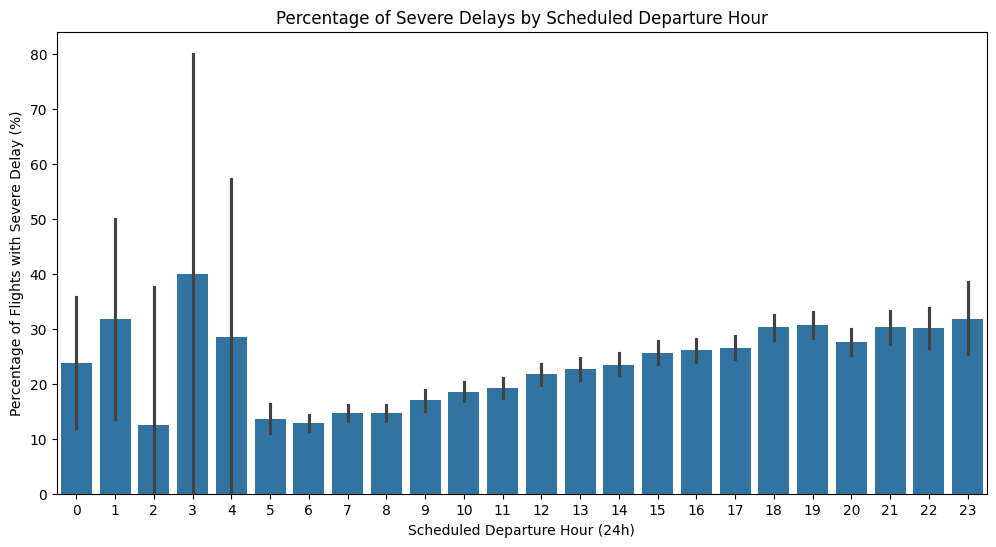

In [8]:
# 2. Barchart of delays by departure hour

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_HOUR', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Percentage of Severe Delays by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour (24h)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

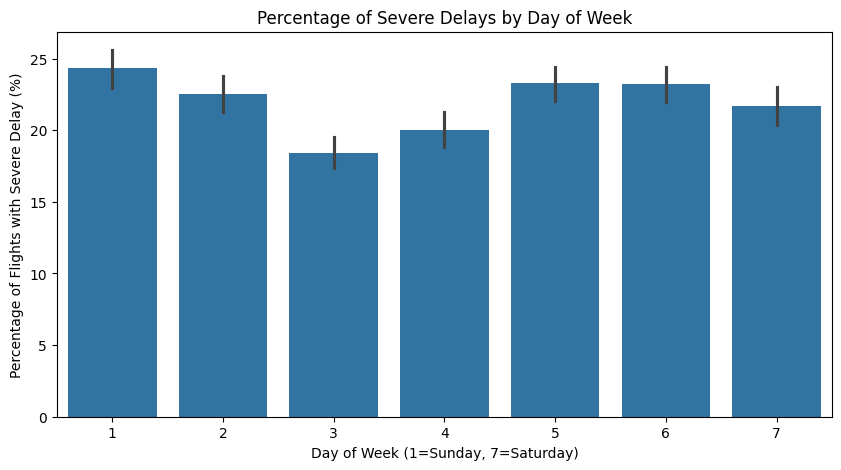

In [9]:
# 3. Delays by Day of the Week

plt.figure(figsize=(10, 5))
sns.barplot(x='DEP_DAY_OF_WEEK', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Day of Week')
plt.xlabel('Day of Week (1=Sunday, 7=Saturday)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

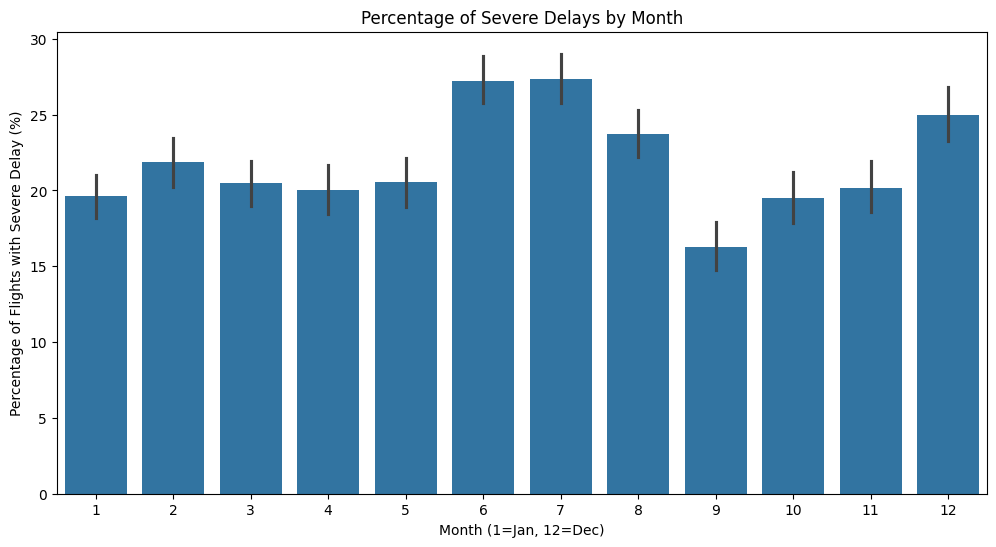

In [10]:
# 4. Delays by Month

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_MONTH', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Month')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

Text(0, 0.5, 'Percentage of Flights with Severe Delay (%)')

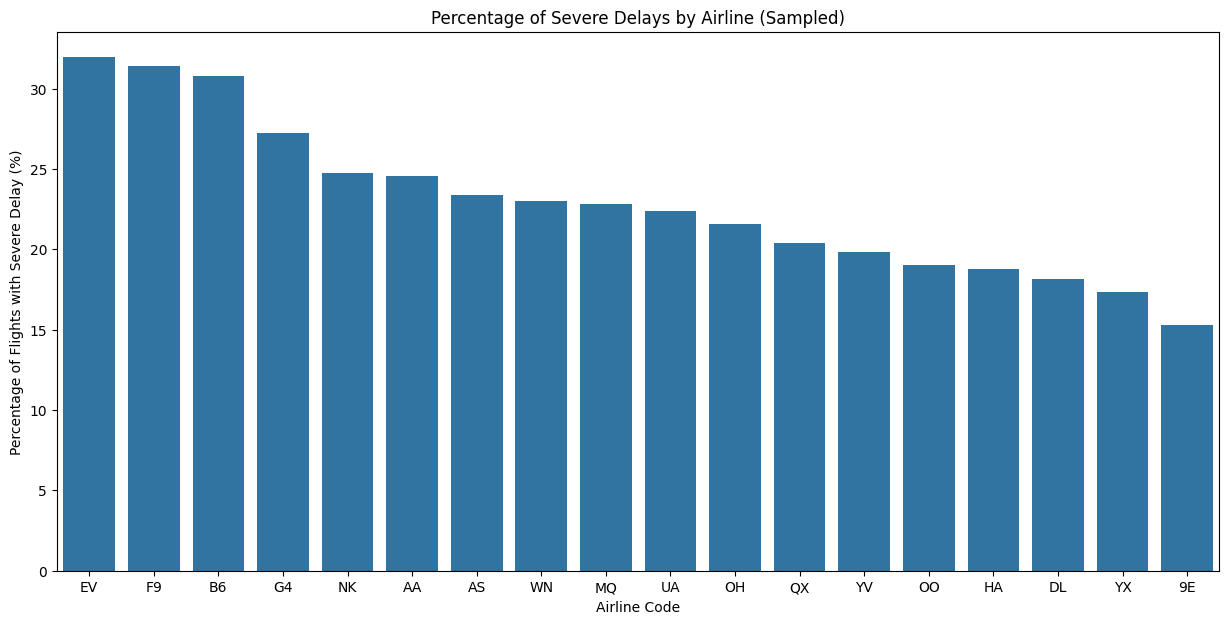

In [11]:
# 5. Top Airlines by Severe Delay Rate (using sampled data)

airline_delay_rate = plot_sample_df.groupby('AIRLINE_CODE')['SEVERE_DELAY'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(15, 7))
sns.barplot(x=airline_delay_rate.index, y=airline_delay_rate.values)
plt.title('Percentage of Severe Delays by Airline (Sampled)')
plt.xlabel('Airline Code')
plt.ylabel('Percentage of Flights with Severe Delay (%)')

Text(0.5, 0, 'Distance (miles)')

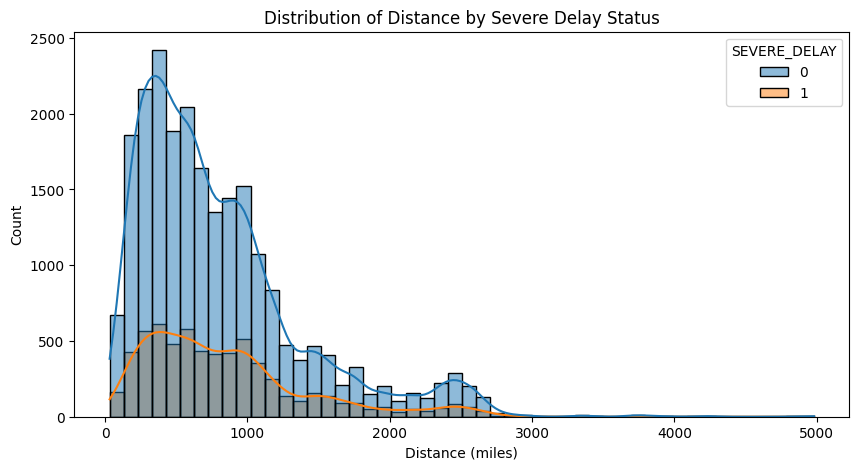

In [12]:
# 6. Numerical Feature Distributions

plt.figure(figsize=(10, 5))
sns.histplot(data=plot_sample_df, x='DISTANCE', hue='SEVERE_DELAY', kde=True, bins=50)
plt.title('Distribution of Distance by Severe Delay Status')
plt.xlabel('Distance (miles)')

# 5. Creating Pipeline

In [13]:
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [
    StringIndexer(inputCol = col, outputCol = col+'Index', handleInvalid = "keep")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol= col+'Index', outputCol = col+'OHE')
    for col in categorical_cols
]

In [14]:
num_vector_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="NumFeatures"
)

In [15]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)

In [16]:
ohe_cols = [col+'OHE' for col in categorical_cols]
final_assembler_inputs = ohe_cols + ["ScaledNumFeatures"]

In [17]:
final_vector_assembler = VectorAssembler(
    inputCols=final_assembler_inputs,
    outputCol="features"
)

In [18]:
pipeline = Pipeline(stages = indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])

In [19]:
pipeline_model = pipeline.fit(final_df)

In [20]:
processed_df = pipeline_model.transform(final_df)
processed_df.printSchema()
processed_df.select("features", labelCol).show(5, truncate=False)

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE_CODEIndex: double (nullable = false)
 |-- ORIGINIndex: double (nullable = false)
 |-- DESTIndex: double (nullable = false)
 |-- AIRLINE_CODEOHE: vector (nullable = true)
 |-- ORIGINOHE: vector (nullable = true)
 |-- DESTOHE: vector (nullable 

# 6. Training Random Forest Model

In [21]:
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)

# i am only using half the data because it broke it otherwise
train_df_sampled = train_df.sample(withReplacement=False, fraction=0.5, seed=101)
print(f"Using {train_df_sampled.count()} samples for training after extra sampling.")

[Stage 21:====================================>                     (5 + 3) / 8]

Using 1166305 samples for training after extra sampling.


In [22]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label",
                            numTrees=100,
                            maxDepth=10,
                            seed=101)

rf_model = rf.fit(train_df_sampled)

25/04/27 14:45:32 WARN MemoryStore: Not enough space to cache rdd_99_5 in memory! (computed 379.6 MiB so far)
25/04/27 14:45:32 WARN BlockManager: Persisting block rdd_99_5 to disk instead.
25/04/27 14:45:32 WARN MemoryStore: Not enough space to cache rdd_99_2 in memory! (computed 379.6 MiB so far)
25/04/27 14:45:32 WARN BlockManager: Persisting block rdd_99_2 to disk instead.
25/04/27 14:45:32 WARN MemoryStore: Not enough space to cache rdd_99_3 in memory! (computed 379.6 MiB so far)
25/04/27 14:45:32 WARN BlockManager: Persisting block rdd_99_3 to disk instead.
25/04/27 14:45:32 WARN MemoryStore: Not enough space to cache rdd_99_4 in memory! (computed 379.6 MiB so far)
25/04/27 14:45:32 WARN BlockManager: Persisting block rdd_99_4 to disk instead.
25/04/27 14:46:11 WARN DAGScheduler: Broadcasting large task binary with size 1214.3 KiB
25/04/27 14:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1781.8 KiB
25/04/27 14:46:39 WARN DAGScheduler: Broadcasting large task b

In [23]:
predictions = rf_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"\nTest Set Area Under ROC (AUC): {auc:.4f}")

25/04/27 14:47:50 WARN DAGScheduler: Broadcasting large task binary with size 2025.1 KiB
                                                                                


Test Set Area Under ROC (AUC): 0.6263


In [24]:
evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
# we are using the weighted metrics because of the imbalance in the data
precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Weighted Precision: {precision:.4f}")
print(f"Test Set Weighted Recall: {recall:.4f}")
print(f"Test Set F1 Score: {f1:.4f}")

25/04/27 14:48:13 WARN DAGScheduler: Broadcasting large task binary with size 2037.4 KiB
25/04/27 14:48:28 WARN DAGScheduler: Broadcasting large task binary with size 2037.4 KiB
25/04/27 14:48:42 WARN DAGScheduler: Broadcasting large task binary with size 2037.4 KiB
25/04/27 14:48:56 WARN DAGScheduler: Broadcasting large task binary with size 2037.4 KiB
[Stage 68:====================================>                     (5 + 3) / 8]

Test Set Accuracy: 0.7785
Test Set Weighted Precision: 0.6061
Test Set Weighted Recall: 0.7785
Test Set F1 Score: 0.6816


In [ ]:
preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

print("\nConfusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Predicted 0 (No Delay)", "Predicted 1 (Severe Delay)"],
            yticklabels=["Actual 0 (No Delay)", "Actual 1 (Severe Delay)"])
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [37]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter = 30, regParam=0.1, elasticNetParam=0.8)
lr_model = lr.fit(train_df_sampled)


In [38]:
lr_predictions = lr_model.transform(test_df)

lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = lr_evaluator.evaluate(lr_predictions)
print(f"\nTest Set Area Under ROC (AUC): {auc:.4f}")

[Stage 190:>                                                        (0 + 8) / 8]


Test Set Area Under ROC (AUC): 0.5000


In [39]:
lr_evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

lr_accuracy = lr_evaluator_multi.setMetricName("accuracy").evaluate(lr_predictions)
lr_precision = lr_evaluator_multi.setMetricName("weightedPrecision").evaluate(lr_predictions)
lr_recall = lr_evaluator_multi.setMetricName("weightedRecall").evaluate(lr_predictions)
lr_f1 = lr_evaluator_multi.setMetricName("f1").evaluate(lr_predictions)

print(f"Test Set Accuracy: {lr_accuracy:.4f}")
print(f"Test Set Weighted Precision: {lr_precision:.4f}")
print(f"Test Set Weighted Recall: {lr_recall:.4f}")
print(f"Test Set F1 Score: {lr_f1:.4f}")

[Stage 207:>                                                        (0 + 8) / 8]

Test Set Accuracy: 0.9178
Test Set Weighted Precision: 0.8423
Test Set Weighted Recall: 0.9178
Test Set F1 Score: 0.8784


In [41]:
from pyspark.sql.functions import when, col

# Step 1: Calculate weights
# Severe delay is rare (~9%) ? weight it more
majority_weight = 0.2    # Smaller
minority_weight = 1.0    # Bigger

train_df_weighted = train_df_sampled.withColumn(
    "classWeightCol",
    when(col("label") == 0, majority_weight).otherwise(minority_weight)
)

# Step 2: Define weighted GBTClassifier
gbt_weighted = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    weightCol="classWeightCol",    # <--- important
    maxIter=50,
    maxDepth=5,
    stepSize=0.1,
    seed=101
)

# Step 3: Train the model
gbt_weighted_model = gbt_weighted.fit(train_df_weighted)

# Step 4: Predict and Evaluate
gbt_weighted_predictions = gbt_weighted_model.transform(test_df)

# Evaluate AUC
gbt_weighted_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
gbt_weighted_auc = gbt_weighted_evaluator.evaluate(gbt_weighted_predictions)
print(f"\nWeighted GBT Test Set Area Under ROC (AUC): {gbt_weighted_auc:.4f}")

# Evaluate Accuracy, Precision, Recall, F1
gbt_weighted_evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

gbt_weighted_accuracy = gbt_weighted_evaluator_multi.setMetricName("accuracy").evaluate(gbt_weighted_predictions)
gbt_weighted_precision = gbt_weighted_evaluator_multi.setMetricName("weightedPrecision").evaluate(gbt_weighted_predictions)
gbt_weighted_recall = gbt_weighted_evaluator_multi.setMetricName("weightedRecall").evaluate(gbt_weighted_predictions)
gbt_weighted_f1 = gbt_weighted_evaluator_multi.setMetricName("f1").evaluate(gbt_weighted_predictions)

print(f"Test Set Accuracy: {gbt_weighted_accuracy:.4f}")
print(f"Test Set Weighted Precision: {gbt_weighted_precision:.4f}")
print(f"Test Set Weighted Recall: {gbt_weighted_recall:.4f}")
print(f"Test Set F1 Score: {gbt_weighted_f1:.4f}")



Weighted GBT Test Set Area Under ROC (AUC): 0.6788


[Stage 1253:=======>                                                (1 + 7) / 8]

Test Set Accuracy: 0.8846
Test Set Weighted Precision: 0.8703
Test Set Weighted Recall: 0.8846
Test Set F1 Score: 0.8770


In [42]:
rf_model = rf.fit(train_df_weighted)

25/04/27 14:32:41 WARN MemoryStore: Not enough space to cache rdd_3025_2 in memory! (computed 379.6 MiB so far)
25/04/27 14:32:41 WARN BlockManager: Persisting block rdd_3025_2 to disk instead.
25/04/27 14:32:41 WARN MemoryStore: Not enough space to cache rdd_3025_6 in memory! (computed 379.6 MiB so far)
25/04/27 14:32:41 WARN BlockManager: Persisting block rdd_3025_6 to disk instead.
25/04/27 14:32:41 WARN MemoryStore: Not enough space to cache rdd_3025_1 in memory! (computed 379.6 MiB so far)
25/04/27 14:32:41 WARN BlockManager: Persisting block rdd_3025_1 to disk instead.
25/04/27 14:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1173.1 KiB
25/04/27 14:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1696.7 KiB
25/04/27 14:33:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
25/04/27 14:33:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/04/27 14:34:19 WARN DAGScheduler: Broadcasting large task binary 

In [43]:
predictions = rf_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"\nTest Set Area Under ROC (AUC): {auc:.4f}")

evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
# we are using the weighted metrics because of the imbalance in the data
precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Weighted Precision: {precision:.4f}")
print(f"Test Set Weighted Recall: {recall:.4f}")
print(f"Test Set F1 Score: {f1:.4f}")

25/04/27 14:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1425.8 KiB
                                                                                


Test Set Area Under ROC (AUC): 0.6496


25/04/27 14:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1438.1 KiB
25/04/27 14:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1438.1 KiB
25/04/27 14:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1438.1 KiB
25/04/27 14:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1438.1 KiB
[Stage 1299:==============>                                         (2 + 6) / 8]

Test Set Accuracy: 0.9178
Test Set Weighted Precision: 0.8423
Test Set Weighted Recall: 0.9178
Test Set F1 Score: 0.8784


In [44]:
pipeline_path = "./flight_delay_pipeline_model"
model_path = "./flight_delay_rf_model"

print(f"\nSaving preprocessing pipeline model to: {pipeline_path}")
pipeline_model.write().overwrite().save(pipeline_path)
print("Pipeline model saved.")

print(f"\nSaving RandomForest model to: {model_path}")
rf_model.write().overwrite().save(model_path)
print("RandomForest model saved.")

spark.stop()
print("\nSpark Session Stopped.")


Saving preprocessing pipeline model to: ./flight_delay_pipeline_model
Pipeline model saved.

Saving RandomForest model to: ./flight_delay_rf_model
RandomForest model saved.

Spark Session Stopped.


# THIS WILL SERVE AS OUR MODELING BUT I LEFT THE TOP STUFF JUST IN CASE

In [1]:
# 1. Import Libraries and Create Spark Session
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.mllib.evaluation import MulticlassMetrics

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/27 19:00:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/27 19:00:46 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:

# 2. Define Schema & Read Data
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

# 3. Cleaning: Drop Irrelevant Fields
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))
columns_to_drop = ['AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT']
df_cleaned = df.drop(*columns_to_drop)

# 4. Drop Nulls
df_cleaned = df_cleaned.dropna(subset=["ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"])

# 5. Outlier Handling
df_cleaned = df_cleaned.filter((F.col("CRS_ELAPSED_TIME") > 0) & (F.col("CRS_ELAPSED_TIME") < 1000))
df_cleaned = df_cleaned.filter((F.col("DISTANCE") > 0) & (F.col("DISTANCE") < 5000))

# 6. Feature Engineering
delay_threshold = 60

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1,7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE")/(F.col("CRS_ELAPSED_TIME")+1e-6))

featureCols = ["AIRLINE_CODE", "ORIGIN", "DEST", "CRS_ELAPSED_TIME", "DISTANCE", "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE", "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR", "IS_WEEKEND", "DISTANCE_PER_MINUTE"]
labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol])

# 7. Build Preprocessing Pipeline
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [StringIndexer(inputCol=col, outputCol=col+'Index', handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+'Index', outputCol=col+'OHE') for col in categorical_cols]
num_vector_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="NumFeatures")
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)
final_vector_assembler = VectorAssembler(inputCols=[col+'OHE' for col in categorical_cols] + ["ScaledNumFeatures"], outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])
pipeline_model = pipeline.fit(final_df)
processed_df = pipeline_model.transform(final_df)


In [5]:

# 8. Train/Test Split
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)

# 9. Handle Class Imbalance
train_df_weighted = train_df.withColumn("classWeightCol", when(col("label") == 0, 0.2).otherwise(1.0))
train_df_weighted = train_df_weighted.sample(withReplacement=False, fraction=0.3, seed=101)
# 10. Train Models



25/04/27 19:05:59 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
25/04/27 19:06:00 WARN MemoryStore: Not enough space to cache rdd_61_2 in memory! (computed 379.6 MiB so far)
25/04/27 19:06:00 WARN MemoryStore: Not enough space to cache rdd_61_1 in memory! (computed 379.6 MiB so far)
25/04/27 19:06:00 WARN MemoryStore: Not enough space to cache rdd_61_6 in memory! (computed 379.6 MiB so far)
25/04/27 19:06:00 WARN MemoryStore: Not enough space to cache rdd_61_4 in memory! (computed 379.6 MiB so far)
25/04/27 19:06:00 WARN MemoryStore: Not enough space to cache rdd_61_5 in memory! (computed 569.5 MiB so far)
25/04/27 19:06:00 WARN MemoryStore: Not enough space to cache rdd_61_0 in memory! (computed 569.5 MiB so far)


In [8]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=30, maxDepth=5, seed=101)
rf_model = rf.fit(train_df_weighted)

25/04/27 19:11:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/04/27 19:11:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/04/27 19:11:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
                                                                                

In [9]:

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=30, regParam=0.1, elasticNetParam=0.8)
lr_model = lr.fit(train_df_weighted)

25/04/27 19:12:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/04/27 19:12:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
                                                                                

In [10]:
gbt = GBTClassifier(featuresCol="features", labelCol="label", weightCol="classWeightCol", maxIter=50, maxDepth=5, stepSize=0.1, seed=101)
gbt_model = gbt.fit(train_df_weighted)

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Random Forest Evaluation:
AUC: 0.6376
Accuracy: 0.9387
Precision: 0.8811
Recall: 0.9387
F1 Score: 0.9090


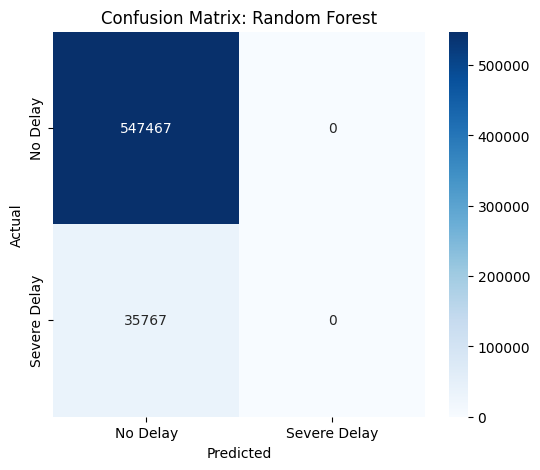

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Logistic Regression Evaluation:
AUC: 0.5000
Accuracy: 0.9387
Precision: 0.8811
Recall: 0.9387
F1 Score: 0.9090


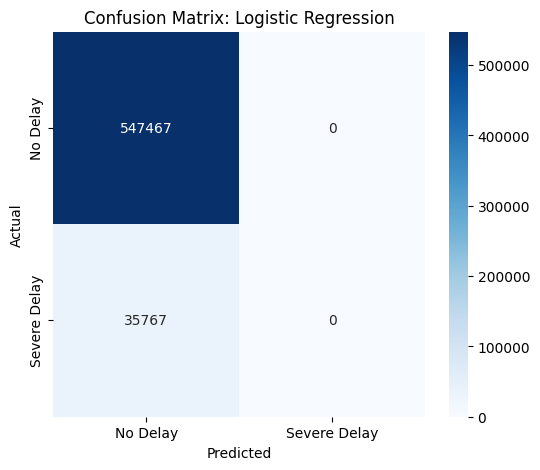

/home/jj/.local/lib/python3.8/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



GBT Evaluation:
AUC: 0.6772
Accuracy: 0.9275
Precision: 0.8972
Recall: 0.9275
F1 Score: 0.9096


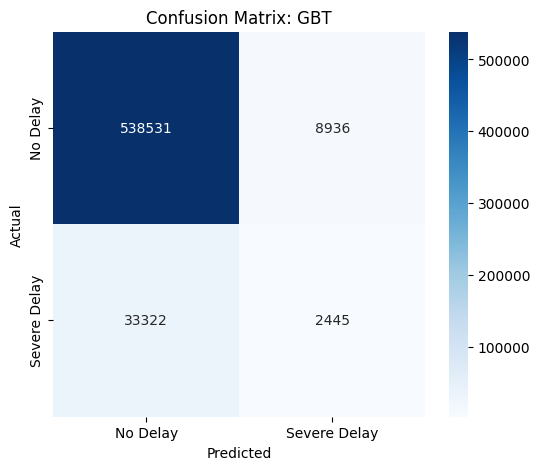

In [11]:
# 11. Evaluate Models
models = {"Random Forest": rf_model, "Logistic Regression": lr_model, "GBT": gbt_model}

for model_name, model in models.items():
    predictions = model.transform(test_df)
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)

    evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
    precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
    f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

    print(f"\n{model_name} Evaluation:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
    metrics = MulticlassMetrics(preds_and_labels)
    cm = metrics.confusionMatrix().toArray()

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=["No Delay", "Severe Delay"],
                yticklabels=["No Delay", "Severe Delay"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [12]:
# Save GBT Model and Pipeline
pipeline_path = "./flight_delay_gbt_pipeline_model"
model_path = "./flight_delay_gbt_model"

pipeline_model.write().overwrite().save(pipeline_path)  # This saves the preprocessing pipeline
gbt_model.write().overwrite().save(model_path)          # <-- Save GBT model here!

spark.stop()
print("\nSpark Session Stopped.")



Spark Session Stopped.
